In [1]:
# Import packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
# Import credit_record.csv
url = "https://raw.githubusercontent.com/manish-cr/CS3244-credit-approval/master/data/credit_record.csv"
df = pd.read_csv(url)

In [38]:
df[df["ID"] == 5001718]

,ID,MONTHS_BALANCE,STATUS
142,5001718,0,C
143,5001718,-1,C
144,5001718,-2,C
145,5001718,-3,0
146,5001718,-4,0
147,5001718,-5,0
148,5001718,-6,0
149,5001718,-7,0
150,5001718,-8,1
151,5001718,-9,X


In [27]:
# Split the data into training and testing sets, keeping customer IDs separate
train_ids, test_ids = train_test_split(df['ID'].unique(), test_size=0.2, random_state=42, stratify=None)

# Create the training and testing data subsets based on the selected customer IDs
train_data = df[df['ID'].isin(train_ids)]
test_data = df[df['ID'].isin(test_ids)]

In [35]:
train_data.shape

(838506, 3)

In [36]:
test_data.shape

(210069, 3)

In [28]:
# Calculate the percentage of "X" and "C" statuses for each customer
x_percentage_train = train_data[train_data['STATUS'] == 'X'].groupby('ID')['MONTHS_BALANCE'].count() / train_data.groupby('ID')['MONTHS_BALANCE'].count()
x_percentage_test = test_data[test_data['STATUS'] == 'X'].groupby('ID')['MONTHS_BALANCE'].count() / test_data.groupby('ID')['MONTHS_BALANCE'].count()

c_percentage_train = train_data[train_data['STATUS'] == 'C'].groupby('ID')['MONTHS_BALANCE'].count() / train_data.groupby('ID')['MONTHS_BALANCE'].count()
c_percentage_test = test_data[test_data['STATUS'] == 'C'].groupby('ID')['MONTHS_BALANCE'].count() / test_data.groupby('ID')['MONTHS_BALANCE'].count()

# Calculate average months overdue for each customer 
avg_months_overdue_train = train_data[train_data['STATUS'].isin(['0', '1', '2', '3', '4', '5'])]
avg_months_overdue_train['STATUS'] = avg_months_overdue_train['STATUS'].astype(int)
avg_months_overdue_train = avg_months_overdue_train.groupby('ID')['STATUS'].mean()

avg_months_overdue_test = test_data[test_data['STATUS'].isin(['0', '1', '2', '3', '4', '5'])]
avg_months_overdue_test['STATUS'] = avg_months_overdue_test['STATUS'].astype(int)
avg_months_overdue_test = avg_months_overdue_test.groupby('ID')['STATUS'].mean()

# Calculate how many months account has been open for
account_length_train = train_data.groupby(['ID'])['MONTHS_BALANCE'].agg(min)
account_length_test = test_data.groupby(['ID'])['MONTHS_BALANCE'].agg(min)

# Create DataFrames for training and testing data
result_train = pd.DataFrame({'ID': train_data['ID'].unique()})
result_test = pd.DataFrame({'ID': test_data['ID'].unique()})

# Merge data for training and testing
result_train = result_train.merge(account_length_train, on='ID', how='left')
result_test = result_test.merge(account_length_test, on='ID', how='left')
result_train = result_train.merge(x_percentage_train, on='ID', how='left')
result_test = result_test.merge(x_percentage_test, on='ID', how='left')
result_train = result_train.merge(c_percentage_train, on='ID', how='left')
result_test = result_test.merge(c_percentage_test, on='ID', how='left')
result_train = result_train.merge(avg_months_overdue_train, on='ID', how='left')
result_test = result_test.merge(avg_months_overdue_test, on='ID', how='left')

result_train = result_train.rename(columns={'MONTHS_BALANCE_x': 'Account_Length', 'MONTHS_BALANCE_y': 'X_Percentage','MONTHS_BALANCE': 'C_Percentage', 'STATUS': 'Avg_Months_Overdue'})
result_test = result_test.rename(columns={'MONTHS_BALANCE_x': 'Account_Length', 'MONTHS_BALANCE_y': 'X_Percentage','MONTHS_BALANCE': 'C_Percentage', 'STATUS': 'Avg_Months_Overdue'})

# Fill NaN values with 0 or -1
result_train['Account_Length'] = -result_train['Account_Length']
result_test['Account_Length'] = -result_test['Account_Length']

result_train['X_Percentage'].fillna(0, inplace=True)  
result_test['X_Percentage'].fillna(0, inplace=True)

result_train['C_Percentage'].fillna(0, inplace=True)  
result_test['C_Percentage'].fillna(0, inplace=True) 

result_train['Avg_Months_Overdue'].fillna(-1, inplace=True)
result_test['Avg_Months_Overdue'].fillna(-1, inplace=True)

/var/folders/xg/6gfgznfs7t72wqwz71mlhlb00000gn/T/ipykernel_51045/531699867.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avg_months_overdue_train['STATUS'] = avg_months_overdue_train['STATUS'].astype(int)
/var/folders/xg/6gfgznfs7t72wqwz71mlhlb00000gn/T/ipykernel_51045/531699867.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avg_months_overdue_test['STATUS'] = avg_months_overdue_test['STATUS'].astype(int)


In [29]:
result_train.head()

,ID,Account_Length,X_Percentage,C_Percentage,Avg_Months_Overdue
0,5001711,3,0.25000,0.000000,0.000000
1,5001713,21,1.00000,0.000000,-1.000000
2,5001714,14,1.00000,0.000000,-1.000000
3,5001717,21,0.00000,0.227273,0.000000
4,5001718,38,0.25641,0.076923,0.076923


In [41]:
result_train.describe()

,ID,Account_Length,X_Percentage,C_Percentage,Avg_Months_Overdue
count,3.678800e+04,36788.000000,36788.000000,36788.000000,36788.000000
mean,5.070104e+06,26.461346,0.214076,0.310426,-0.095367
std,4.539763e+04,16.473163,0.331039,0.356100,0.405026
min,5.001711e+06,0.000000,0.000000,0.000000,-1.000000
25%,5.026156e+06,12.000000,0.000000,0.000000,0.000000
50%,5.065716e+06,25.000000,0.032258,0.000000,0.000000
75%,5.113996e+06,40.000000,0.296296,0.675676,0.000000
max,5.150487e+06,60.000000,1.000000,1.000000,5.000000


In [30]:
result_test.head()

,ID,Account_Length,X_Percentage,C_Percentage,Avg_Months_Overdue
0,5001712,18,0.000,0.473684,0.0
1,5001715,59,1.000,0.000000,-1.0
2,5001719,42,0.000,0.953488,0.0
3,5001725,7,0.125,0.000000,0.0
4,5001728,0,0.000,0.000000,0.0


In [7]:
# Create a copy of result_train and result_test
result_train_normalised = result_train.copy()
result_test_normalised = result_test.copy()

# Define the custom normalization function
def custom_normalize(x, min_val, max_val):
    return (x - min_val) / (max_val - min_val)

# Define the columns to be normalized
columns_to_normalize = ['Avg_Months_Overdue', 'Account_Length']

# Calculate min and max values for the selected columns in the training data
min_values_train = result_train_normalised[columns_to_normalize].min()
max_values_train = result_train_normalised[columns_to_normalize].max()

# Calculate min and max values for the selected columns in the testing data
min_values_test = result_test_normalised[columns_to_normalize].min()
max_values_test = result_test_normalised[columns_to_normalize].max()

# Apply custom normalization to the selected columns in the training data
for column in columns_to_normalize:
    result_train_normalised[column] = result_train_normalised[column].apply(custom_normalize, args=(min_values_train[column], max_values_train[column]))

# Apply custom normalization to the selected columns in the testing data
for column in columns_to_normalize:
    result_test_normalised[column] = result_test_normalised[column].apply(custom_normalize, args=(min_values_test[column], max_values_test[column]))

In [8]:
result_train_normalised.describe()

,ID,Account_Length,X_Percentage,C_Percentage,Avg_Months_Overdue
count,3.678800e+04,36788.000000,36788.000000,36788.000000,36788.000000
mean,5.070104e+06,0.441022,0.214076,0.310426,0.150772
std,4.539763e+04,0.274553,0.331039,0.356100,0.067504
min,5.001711e+06,0.000000,0.000000,0.000000,0.000000
25%,5.026156e+06,0.200000,0.000000,0.000000,0.166667
50%,5.065716e+06,0.416667,0.032258,0.000000,0.166667
75%,5.113996e+06,0.666667,0.296296,0.675676,0.166667
max,5.150487e+06,1.000000,1.000000,1.000000,1.000000


In [9]:
result_test_normalised.describe()

,ID,Account_Length,X_Percentage,C_Percentage,Avg_Months_Overdue
count,9.197000e+03,9197.000000,9197.000000,9197.000000,9197.000000
mean,5.070402e+06,0.438701,0.211049,0.311734,0.154367
std,4.557908e+04,0.275236,0.328737,0.356109,0.068904
min,5.001712e+06,0.000000,0.000000,0.000000,0.000000
25%,5.026118e+06,0.200000,0.000000,0.000000,0.169550
50%,5.065839e+06,0.400000,0.031250,0.000000,0.169550
75%,5.114159e+06,0.666667,0.285714,0.676471,0.169550
max,5.150480e+06,1.000000,1.000000,1.000000,1.000000


In [10]:
percentile_95 = result_train_normalised['Avg_Months_Overdue'].quantile(0.95)

# Print the result
print("95th percentile of Avg_Months_Overdue:", percentile_95)

95th percentile of Avg_Months_Overdue: 0.19444444444444445


In [13]:
percentile_95 = result_test_normalised['Avg_Months_Overdue'].quantile(0.95)

# Print the result
print("95th percentile of Avg_Months_Overdue:", percentile_95)

95th percentile of Avg_Months_Overdue: 0.20346020761245673


In [14]:
# Define criteria for "bad" and "good" credit records
# Adjust these thresholds as needed
c_percentage_low = 0.0 # never paid off
avg_months_overdue_high = 0.195 # 95% of Avg_Months_Overdue

# Create a new column 'Credit_Status' based on your criteria
result_train_normalised['Credit_Status'] = 'Good'  # Initialize as 'Good'
result_test_normalised['Credit_Status'] = 'Good'

# Update the 'Credit_Status' based on the criteria
result_train_normalised.loc[
    (result_train_normalised['C_Percentage'] <= c_percentage_low) &
    (result_train_normalised['Avg_Months_Overdue'] >= avg_months_overdue_high), 'Credit_Status'] = 'Bad'

result_test_normalised.loc[
    (result_test_normalised['C_Percentage'] <= c_percentage_low) &
    (result_test_normalised['Avg_Months_Overdue'] >= avg_months_overdue_high), 'Credit_Status'] = 'Bad'

In [15]:
# In the case where there is no loans at all (X_percentage == 1), we will consider this as a credit ghost
# and rate credit record as good

result_train_normalised.loc[
    (result_train_normalised['X_Percentage'] == 1), 'Credit_Status'] = 'Good'

result_test_normalised.loc[
    (result_test_normalised['X_Percentage'] == 1), 'Credit_Status'] = 'Good'

In [16]:
credit_status_counts_train = result_train_normalised['Credit_Status'].value_counts()
credit_status_counts_test = result_test_normalised['Credit_Status'].value_counts()

# Print the counts
print(credit_status_counts_train)
print(credit_status_counts_test)

# Balanced split 

Good    36004
Bad       784
Name: Credit_Status, dtype: int64
Good    8975
Bad      222
Name: Credit_Status, dtype: int64


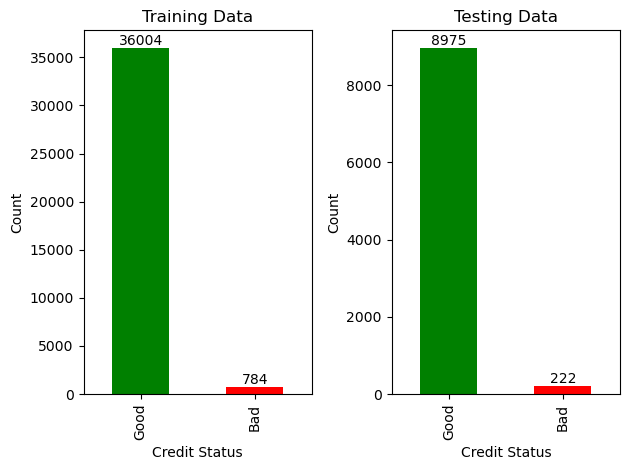

In [21]:
# Function to annotate bars with counts
def annotate_bars(ax, counts):
    for i, count in enumerate(counts):
        ax.text(i, count + 0.1, str(count), ha='center', va='bottom')

# Create a bar plot for the training data
plt.subplot(1, 2, 1)
credit_status_counts_train.plot(kind='bar', color=['green', 'red'])
plt.title('Training Data')
plt.xlabel('Credit Status')
plt.ylabel('Count')
annotate_bars(plt.gca(), credit_status_counts_train)

# Create a bar plot for the testing data
plt.subplot(1, 2, 2)
credit_status_counts_test.plot(kind='bar', color=['green', 'red'])
plt.title('Testing Data')
plt.xlabel('Credit Status')
plt.ylabel('Count')
annotate_bars(plt.gca(), credit_status_counts_test)

plt.tight_layout()
plt.show()


Another Approach Attempted - K-Means Clustering

In [22]:
# Apply K-Means clustering to the training data
kmeans = KMeans(n_clusters=2, random_state=20)  
result_train_normalised['Label'] = 
kmeans.fit_predict(result_train_normalised[['Account_Length', 'X_Percentage', 'C_Percentage', 'Avg_Months_Overdue']])

# Predict cluster labels for the testing data using the same K-Means model
result_test_normalised['Label'] = 
kmeans.fit_predict(result_test_normalised[['Account_Length', 'X_Percentage', 'C_Percentage', 'Avg_Months_Overdue']])

In [23]:
# Group the DataFrame by the 'Cluster' column and count the data points in each cluster
cluster_counts_train = result_train_normalised.groupby('Label').size().reset_index(name='Count')
cluster_counts_test = result_test_normalised.groupby('Label').size().reset_index(name='Count')

# Display the cluster counts
print("training cluster counts:")
print(cluster_counts_train)
print("test cluster counts:")
print(cluster_counts_test)

# 0 for good credit record and 1 for bad credit record 

training cluster counts:
   Label  Count
0      0  21135
1      1  15653
test cluster counts:
   Label  Count
0      0   5264
1      1   3933


In [112]:
#result_train_normalised.to_csv('../data/credit_cleaned_training_threelabels.csv', encoding = 'utf-8-sig')
#result_test_normalised.to_csv('../data/credit_cleaned_test_threelabels.csv', encoding = 'utf-8-sig')
#result_train_normalised.to_csv('../data/credit_cleaned_training_twolabels.csv', encoding = 'utf-8-sig')
#result_test_normalised.to_csv('../data/credit_cleaned_test_twolabels.csv', encoding = 'utf-8-sig')